In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


C:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


C:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

experiments.2Q_state_tomography
experiments.amplitude_rabi
experiments.amplitude_rabi_ef
experiments.amplitude_rabi_EgGf
experiments.clifford_averager_program
experiments.fitting
experiments.length_rabi
experiments.length_rabi_EgGf
experiments.pulse_probe_ef_spectroscopy
experiments.pulse_probe_EgGf_spectroscopy
experiments.pulse_probe_spectroscopy
experiments.ramsey_ef
experiments.randbench
experiments.resonator_spectroscopy
experiments.rfsoc_tof_calibration
experiments.single_shot
experiments.t1
experiments.t2_echo
experiments.t2_ramsey


In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.getcwd()+'\data'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\slab_rfsoc_expts\data


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\slab_rfsoc_expts\config_q3diamond.yml


In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)

# Set the qubits/resonators to probe

In [45]:
qubits = [3, 1]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [8]:
im = InstrumentManager()

In [10]:
lo1 = im[yaml_cfg['aliases']['readout_LO']]
lo1.open_device()
print(lo1.get_id())
# lo1.set_standby(True)
# lo1.set_output_state(False) # TURN ON/OFF
lo1.set_standby(False)
lo1.set_output_state(True) # TURN ON/OFF

lo1.set_frequency(float(yaml_cfg['hw']['lo']['readout']['frequency'])) # Set LO frequency
lo1.set_power(float(yaml_cfg['hw']['lo']['readout']['power'])) # Set LO power

Default Instrument SC26C3


0

In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# Pulse probe eg-gf spectroscopy

In [46]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 10
npts = 15

qEgGfspec.cfg.expt = dict(
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=3600,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=20, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=10, # Eg-Gf probe constant pulse length [us]
    gain=10000, # Eg-Gf const pulse gain
    qubits=qubits,
)
# qEgGfspec.cfg.device.readout.relax_delay = [50,50] # Wait time between experiments [us]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/10 [00:00<?, ?it/s]

(4, 1, 15)


(15,) (15,)


C:\Users\slab\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


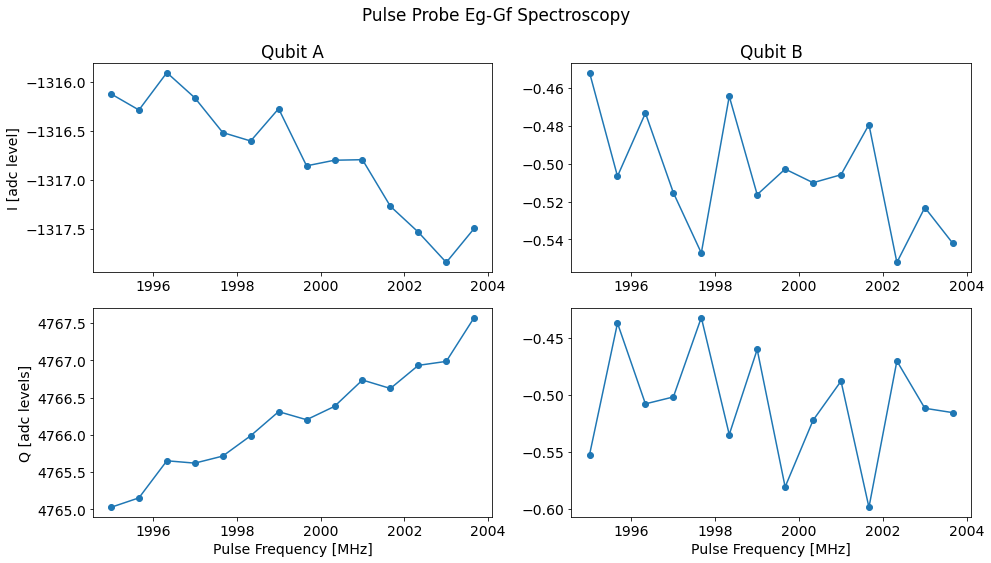

In [34]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
qEgGfspec.analyze(fit=True, sign=[[1, -1], [-1, -1]])
qEgGfspec.display(fit=False)

In [73]:
qEgGfspec.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00002_qubit_EgGf_spectroscopy_qubit01.h5


# Length Rabi eg-gf

In [23]:
soc.us2cycles(15/100)

58

In [39]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiEgGf.cfg.expt = dict(
    start=soc.cycles2us(5), # pulse length (sigma) [us]
    step=soc.cycles2us(10), # [us]
    # step=0.001,
    expts=15,
    reps=100,
    gain=10000, # qubit gain [DAC units],
    pulse_type='const',
    qubits=qubits,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
lengthrabiEgGf.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/15 [00:00<?, ?it/s]

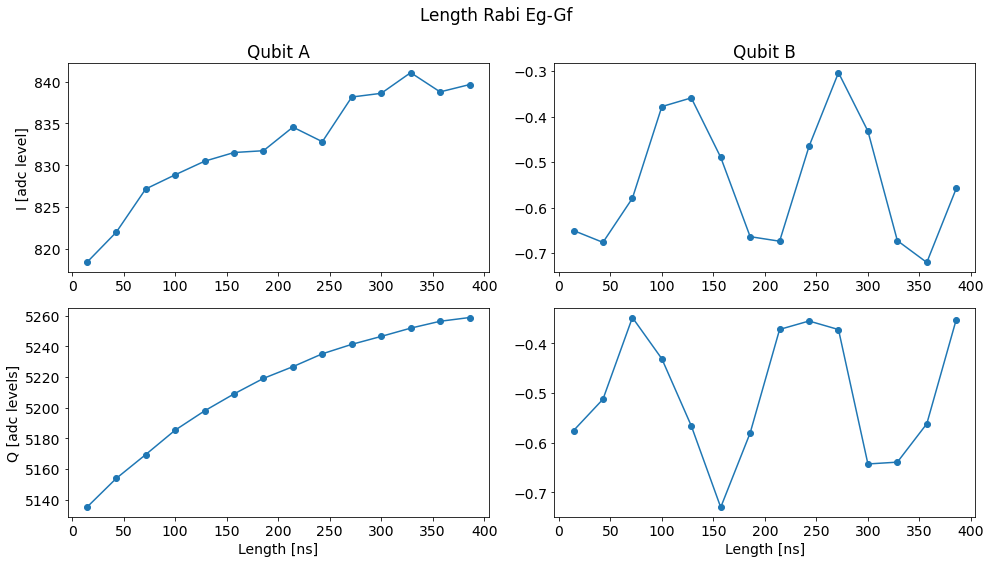

In [40]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=False)
lengthrabiEgGf.display(fit=False)

In [78]:
lengthrabiEgGf.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_length_rabi_qubit01.h5


# Amplitude Rabi eg-gf

In [43]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 32000
npts = 15
    
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    rounds=10,
    reps=10,
    pi_EgGf_sigma=0.400, # gaussian sigma for pulse length [us]
    pulse_type='gauss',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/10 [00:00<?, ?it/s]

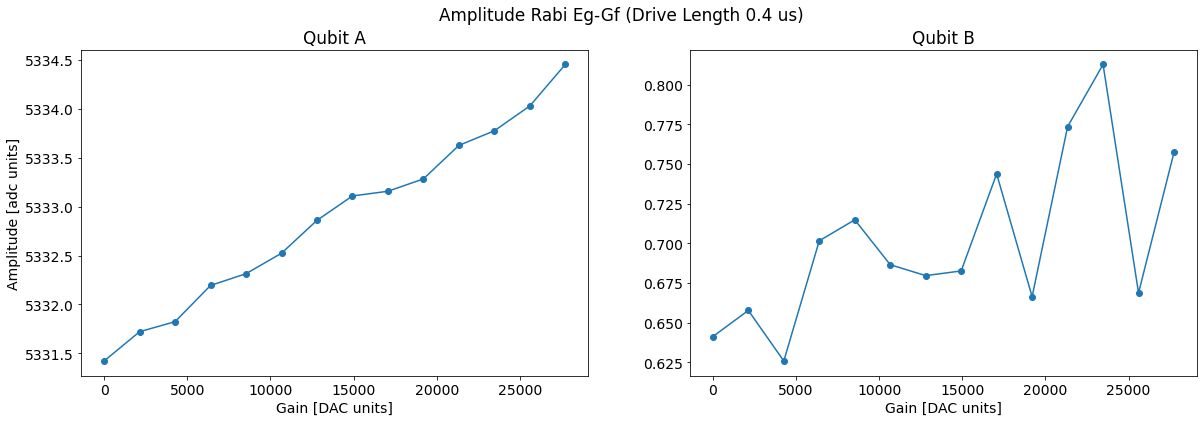

In [44]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

amprabiEgGf.analyze(fit=False)
amprabiEgGf.display(fit=False)

In [120]:
amprabiEgGf.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_amp_rabi_EgGf_qubit01.h5


In [149]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

50 23 16 11
